Model Params:
input_size: 7, conv_filters: 32
lstm_hidden_size: 128, lstm_layers: 2
output_size: 1, learning_rate: 0.001, num_epochs: 100
Model Summary:
Layer (type:depth-idx)                   Output Shape              Param #
CNNLSTM                                  [32, 1]                   --
├─Conv1d: 1-1                            [32, 32, 7]               128
├─ReLU: 1-2                              [32, 32, 7]               --
├─LSTM: 1-3                              [32, 7, 128]              215,040
├─Linear: 1-4                            [32, 1]                   129
Total params: 215,297
Trainable params: 215,297
Non-trainable params: 0
Total mult-adds (M): 48.20
Input size (MB): 0.00
Forward/backward pass size (MB): 0.29
Params size (MB): 0.86
Estimated Total Size (MB): 1.15
Epoch [10/100], Train Loss: 0.0851, Val Loss: 0.0448
Epoch [20/100], Train Loss: 0.0393, Val Loss: 0.0216
Epoch [30/100], Train Loss: 0.0269, Val Loss: 0.0071
Epoch [40/100], Train Loss: 0.0213, Val Lo

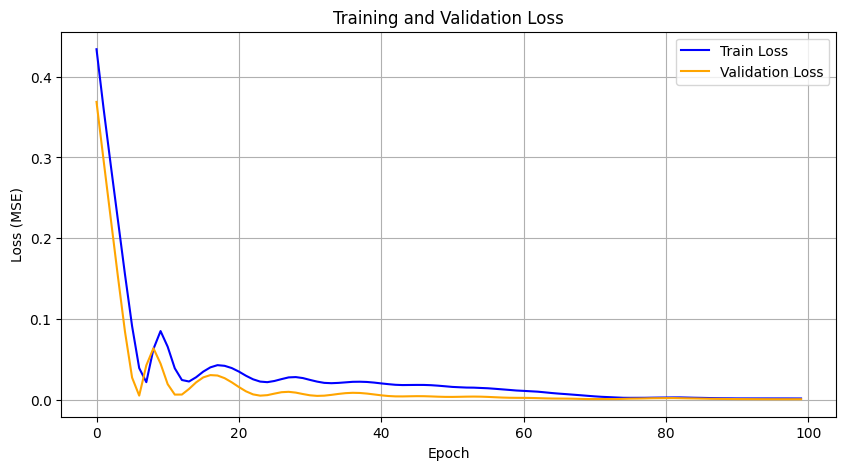

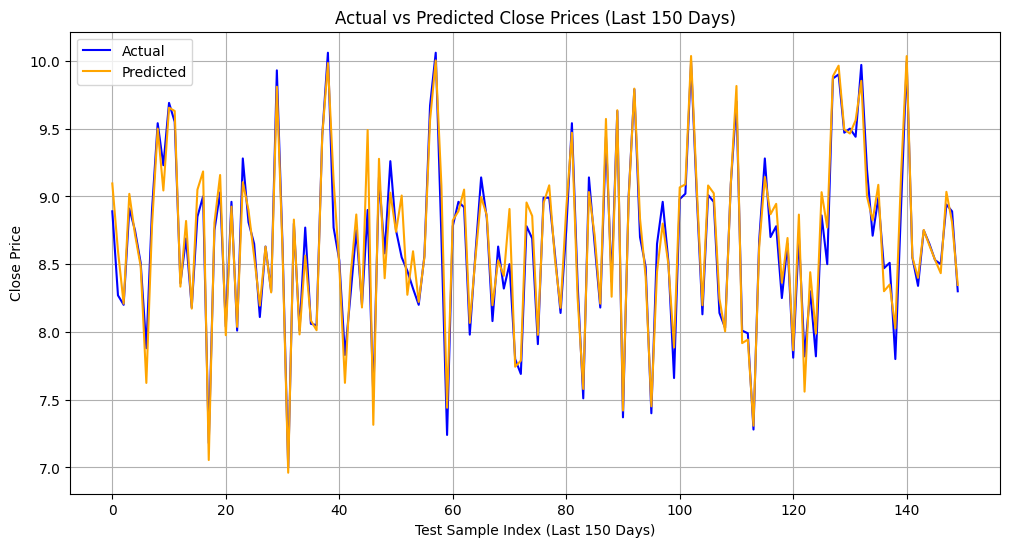

Evaluating Loaded Model:
MAE: 0.1139
MSE: 0.0287
RMSE: 0.1695
MAPE: 1.35%
R2 Score: 0.9285


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import joblib
from torchinfo import summary

# Step 1: Load data
data = pd.read_csv("data/selected_features_df.csv")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.dropna(inplace=True)

# Step 2: Normalize features and target using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_X.fit_transform(data.drop(columns=['Close']))
y = scaler_y.fit_transform(data[['Close']])

# Step 3: Split data into train (70%), val (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert data to PyTorch tensors and reshape for CNN-LSTM
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to("cuda")  # Add sequence dimension
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1).to("cuda")
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to("cuda")
y_train = torch.tensor(y_train, dtype=torch.float32).to("cuda")
y_val = torch.tensor(y_val, dtype=torch.float32).to("cuda")
y_test = torch.tensor(y_test, dtype=torch.float32).to("cuda")

# Step 4: Define CNN-LSTM Model
class CNNLSTM(nn.Module):
    def __init__(self, input_size, conv_filters, lstm_hidden_size, lstm_layers, output_size):
        super(CNNLSTM, self).__init__()
        self.conv1d = nn.Conv1d(1, conv_filters, kernel_size=3, stride=1, padding=1)  # Conv1D layer
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(conv_filters, lstm_hidden_size, lstm_layers, batch_first=True, dropout=0.2)  # LSTM
        self.fc = nn.Linear(lstm_hidden_size, output_size)  # Fully connected layer

    def forward(self, x):
        batch_size, seq_len, features = x.size()  # Input: (batch, seq_len, features)
        x = x.view(batch_size, 1, seq_len * features)  # Reshape for Conv1D: (batch, 1, seq_len * features)
        x = self.conv1d(x)  # Apply Conv1D
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # Permute to (batch, seq_len, conv_filters) for LSTM
        out, _ = self.lstm(x)  # LSTM layer
        out = self.fc(out[:, -1, :])  # Fully connected layer on the last time step
        return out

# Initialize model and hyperparameters
input_size = X_train.size(-1)  # Number of features
conv_filters = 32
lstm_hidden_size = 128
lstm_layers = 2
output_size = 1
learning_rate = 1e-3
num_epochs = 100

print("Model Params:")
print(f"input_size: {input_size}, conv_filters: {conv_filters}")
print(f"lstm_hidden_size: {lstm_hidden_size}, lstm_layers: {lstm_layers}")
print(f"output_size: {output_size}, learning_rate: {learning_rate}, num_epochs: {num_epochs}")

model = CNNLSTM(input_size, conv_filters, lstm_hidden_size, lstm_layers, output_size).to("cuda")

# Print the model summary
print("Model Summary:")
print(summary(model, input_size=(32, 1, input_size), device="cuda"))  # Batch size = 32

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Step 5: Train the model
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    train_output = model(X_train)
    train_loss = criterion(train_output, y_train)
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        val_losses.append(val_loss.item())

    # Print losses every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", color="blue")
plt.plot(val_losses, label="Validation Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

# # Save model and scalers
# torch.save(model.state_dict(), "trained_model/cnn-lstm/cnn_lstm_model.pth")
# joblib.dump(scaler_X, "trained_model/cnn-lstm/scaler_X.pkl")
# joblib.dump(scaler_y, "trained_model/cnn-lstm/scaler_y.pkl")

# Step 6: Evaluate the model
model.eval()
with torch.no_grad():
    test_output = model(X_test).cpu().numpy()
    y_test_actual = scaler_y.inverse_transform(y_test.cpu().numpy())
    test_predictions = scaler_y.inverse_transform(test_output)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_actual, test_predictions)
mse = mean_squared_error(y_test_actual, test_predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_actual - test_predictions) / y_test_actual)) * 100
r2 = r2_score(y_test_actual, test_predictions)

# Step 7: Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual[-150:], label="Actual", color="blue")
plt.plot(test_predictions[-150:], label="Predicted", color="orange")
plt.xlabel("Test Sample Index (Last 150 Days)")
plt.ylabel("Close Price")
plt.title("Actual vs Predicted Close Prices (Last 150 Days)")
plt.legend()
plt.grid()
plt.show()

# Print results
print("Evaluating Loaded Model:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2 Score: {r2:.4f}")


In [3]:
# Save model and scalers
torch.save(model.state_dict(), "trained_model/cnn-lstm/cnn_lstm_model.pth")
joblib.dump(scaler_X, "trained_model/cnn-lstm/scaler_X.pkl")
joblib.dump(scaler_y, "trained_model/cnn-lstm/scaler_y.pkl")

['trained_model/cnn-lstm/scaler_y.pkl']